# **Hyperparameter Tuning II**

Model parameters thus far:
- Hidden size of 256
- Number of attention heads: 8
- Number of layers: 4
- MLP Ratio: 4
- Dropout: 0.2
- Positional Encoding: Learned

Hyperparameters thus far:
- Batch size remains at 64 for future experiments.
- Lion optimizer initialized with a learning rate of 0.0001

**Objective:**

Perform experiments with weight decay, learning rate scheduling strategies (with warmup), and different gradient clipping variations in no particular order. Determine whether each experiment improves performance/regulates performance while improving generalization/stability/faster convergence. If so, include them inside the training procedure.

**Evaluation metrics**

Some experiments here require metrics for evaluating training stability:
- Loss (for both validation and training): the averaged cross-entropy loss over all positions
- Total Training time: the length of training time
- Smoothness of training/validation loss curves (to check for erratic changes in loss)
- Convergence rates for loss curves (to check how quickly the model converges to an optimal solution, in this case, a threshold of 1.5 is used)

### **Importing**

In [ ]:
# Import all modules and functions
import scripts.functions as functions
from functions import *

In [ ]:
# Import train and test sets
train_text_int = np.load("train_text_int.npy")
test_text_int = np.load("test_text_int.npy")

# For model tuning, separate train_text_int into training and validation sets
print(len(train_text_int))

# 1/9 of the training set will be used for validation
val_text_int = train_text_int[-10_000_000:]
training_text_int = train_text_int[:80_000_000]
print(len(val_text_int))
print(len(training_text_int))

90000000
10000000
80000000


In [ ]:
# Import model
import models.transformer_III as intermediate_transformer

In [ ]:
# a single gradient update
def train_step(params, opt_state, x, y, tx):
    """
    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B_seq, B_tok) int array input tokens.
      y: (B_seq, B_tok) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients of loss w.r.t params (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: update params and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

In [ ]:
import yaml

with open("./conf/config4.yml", "r") as f:
    cfg = yaml.safe_load(f)
    print(cfg)

# model parameters
vocab_size = cfg['vocab_size']
d_model = cfg['d_model']
n_layers = cfg['n_layers']
n_heads = cfg['n_heads']
max_len = cfg['max_len']
activation = cfg['activation']
mlp_ratio = cfg['mlp_ratio']
dropout = cfg['dropout']

# hyperparameters
lr = cfg['learning_rate']
weight_decay = cfg['weight_decay']
gradient_clipping = cfg['gradient_clipping']
adaptive_gradient = cfg['adapt_grad_clipping']

{'vocab_size': 27, 'd_model': 256, 'n_layers': 4, 'n_heads': 8, 'max_len': 128, 'activation': 'GeLU', 'mlp_ratio': 4, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': [0.01, 0.001, 0.0001], 'gradient_clipping': [0.1, 0.5, 1.0, 2.0], 'adapt_grad_clipping': [0.01, 0.1, 0.5, 1.0]}


In [ ]:
# Initialize the model architecture and params
def create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout):
    model = intermediate_transformer.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout)

    # Create dummy input for initialization of batch size 1, seq length min(16, max_len)
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # Initialize the parameters and extracts the PyTree of params
    params = model.init({"params": key}, dummy)["params"]
    return model, params

## **Weight decay**

Different decoupled weight decay values are experimented with the Lion optimizer.

**An insight:** Adam typically uses L2 regularization (added to the loss) while AdamW uses decoupled weight decay (applied directly to the weights), which is generally better. Lion, as with AdamW, uses decoupled weight decay.

In [ ]:
# The weight decay values used
print(weight_decay)

[0.01, 0.001, 0.0001]


Experiment with different decoupled weight decay values. If any of these experiments outperform the control setup (without weight decay) in performance, proceed to test for which value provides the best generalization.

In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []

for w in weight_decay:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    tx = optax.lion(learning_rate = lr, weight_decay = w)
    print(f"Initialized Lion optimizer with weight decay of {w}")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Initialized Lion optimizer with weight decay of 0.01
Initialized Lion optimizer with weight decay of 0.001
Initialized Lion optimizer with weight decay of 0.0001


Plot three validation loss curves side by side for visualization.

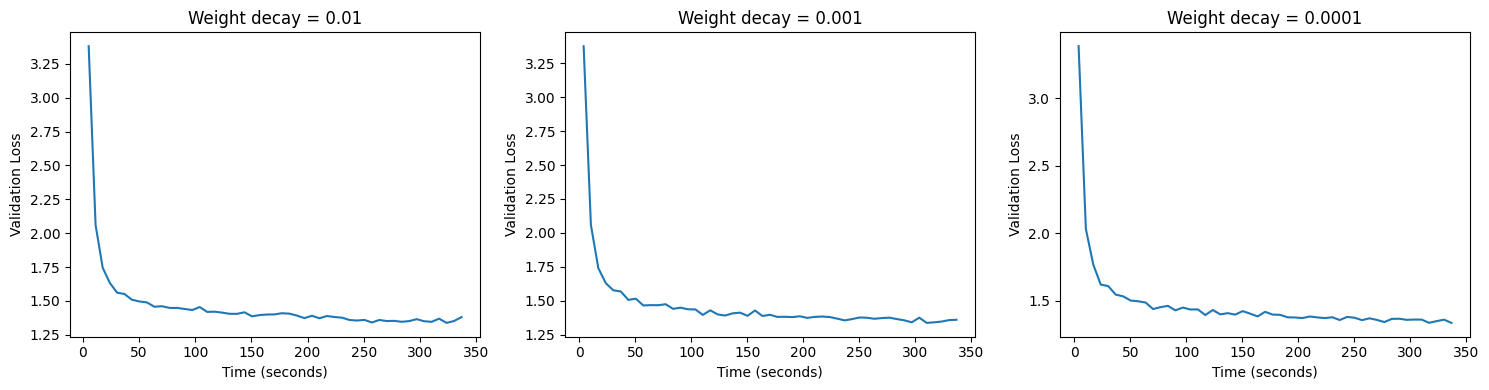

In [ ]:
plt.figure(figsize=(15, 4))

for i in range(len(weight_decay)):
    plt.subplot(1, 3, i + 1)
    plt.plot(val_time_all[i], val_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Loss")
    plt.title(f"Weight decay = {weight_decay[i]}")

plt.tight_layout()
plt.show()

In [ ]:
for i in range(0, len(weight_decay)):
    string = f"""
    Lion optimizer initialized with a weight decay of {weight_decay[i]},
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Lion optimizer initialized with a weight decay of 0.01,
    Final validation loss: 1.3810458183288574
    Total Training Time: 336.96729922294617
    Minimum validation loss: 1.3382458686828613 attained at 323.6557078361511 seconds
    

    Lion optimizer initialized with a weight decay of 0.001,
    Final validation loss: 1.3596346378326416
    Total Training Time: 336.85369181632996
    Minimum validation loss: 1.3368161916732788 attained at 310.26463747024536 seconds
    

    Lion optimizer initialized with a weight decay of 0.0001,
    Final validation loss: 1.3347238302230835
    Total Training Time: 336.80415534973145
    Minimum validation loss: 1.3347238302230835 attained at 336.80415534973145 seconds
    


### **Evaluation on weight decay**

It appears that adding weight decay to the optimizer makes the optimizer's performance slightly worse. The training data is a substantial amount, so it is unlikely for the model to overfit the data.

While weight decay may be good to anchor parameter magnitudes, large weight decay values can cause the optimizer to underfit the data as a result of slow learning, causing a slight reduction in performance due to slower convergence rates. Dropout is also already added inside the transformer heads for regularization.

Moving forward, no weight decay will be initialized with the optimizer in future experiments, as there is a drop in model performance.

## **Gradient clipping**

There are two phases to this section:
- First phase involves clipping gradients by their global L2 norm.
- Second phase uses an adaptive approach; adjusting the clipping threshold based on some metrics. In this case, the clipping value is not fixed as in the first phase, potentially leading to more stable training.

Evaluation metrics:
- Smoothness of training and validation loss (verify if training is stable)
- Performance of the model on validation set (minimize averaged cross-entropy loss over all tokens) and training time

In [ ]:
lr = cfg['learning_rate']
print(gradient_clipping)

[0.1, 0.5, 1.0, 2.0]


In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []
training_loss_all = []
training_time_all = []

for g in gradient_clipping:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    tx = optax.chain(
        optax.clip_by_global_norm(g),
        optax.lion(learning_rate = lr)
    )
    print(f"Initialized Lion optimizer with global-norm clipping of a fixed value {g}")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_train_history = []
    loss_train_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new
        train_loss = metrics['loss']

        # Keep track of the loss and time
        loss_train_history.append(train_loss)
        time_train_history.append(time.time() - time_start)

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)
    training_loss_all.append(loss_train_history)
    training_time_all.append(time_train_history)

Initialized Lion optimizer with global-norm clipping of a fixed value 0.1
Initialized Lion optimizer with global-norm clipping of a fixed value 0.5
Initialized Lion optimizer with global-norm clipping of a fixed value 1.0
Initialized Lion optimizer with global-norm clipping of a fixed value 2.0


The plots below show the graphs of training loss over time. This is part of evaluation for the best fixed gradient clipping value, as training stability is crucial here.

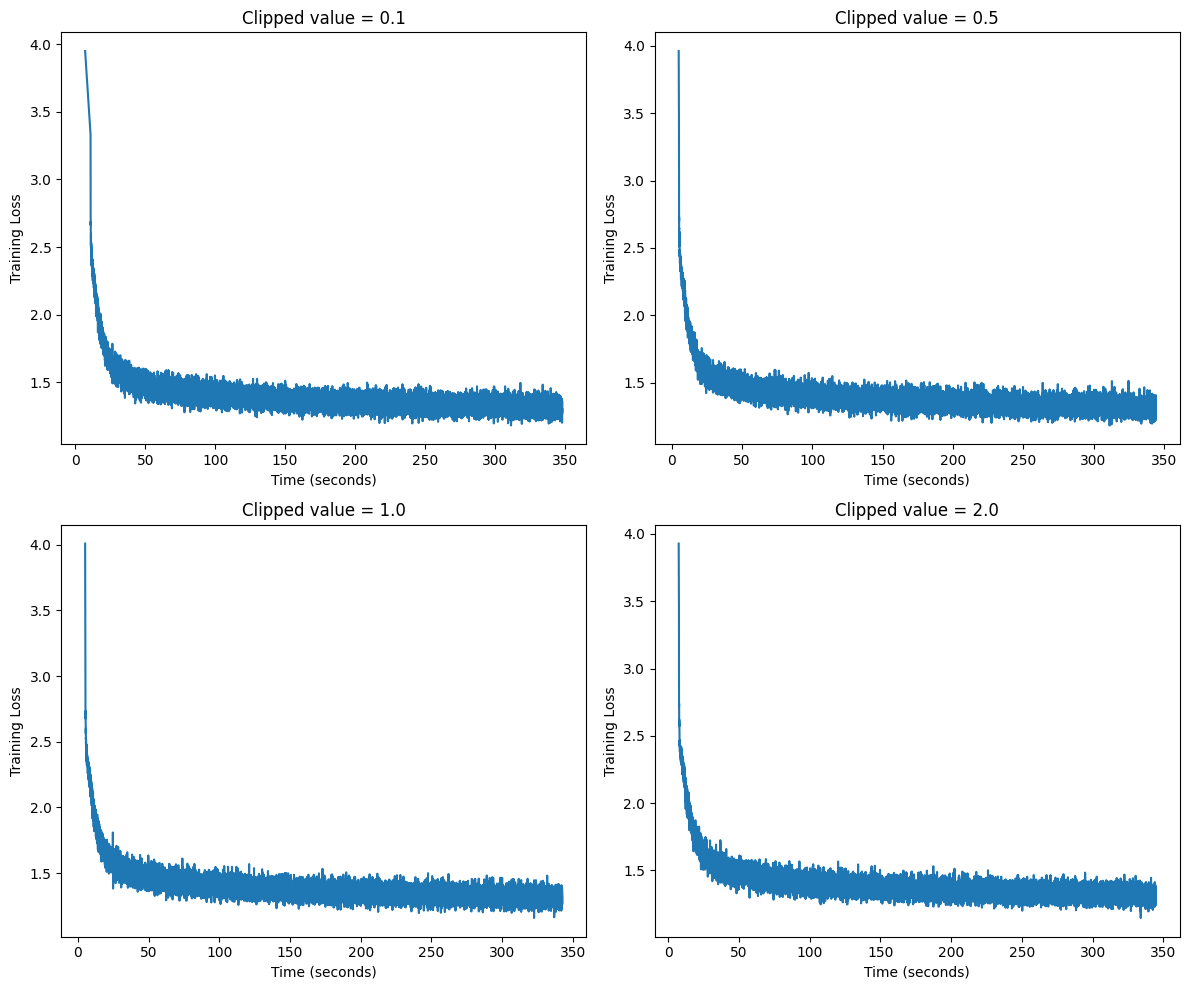

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(len(gradient_clipping)):
    plt.subplot(2, 2, i + 1)
    plt.plot(training_time_all[i], training_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Training Loss")
    plt.title(f"Clipped value = {gradient_clipping[i]}")

plt.tight_layout()
plt.show()


The plots below show the performances of each optimizer variant on the validation set. This is part of evaluation for the best fixed gradient clipping value, as an ideal clipping value should stabilize training without overly suppressing useful gradient information. It is preferred to have fewer erratic jumps in validation loss.

**Disclaimer:** Ignore the training loss of the y-axis. It should be validation loss.

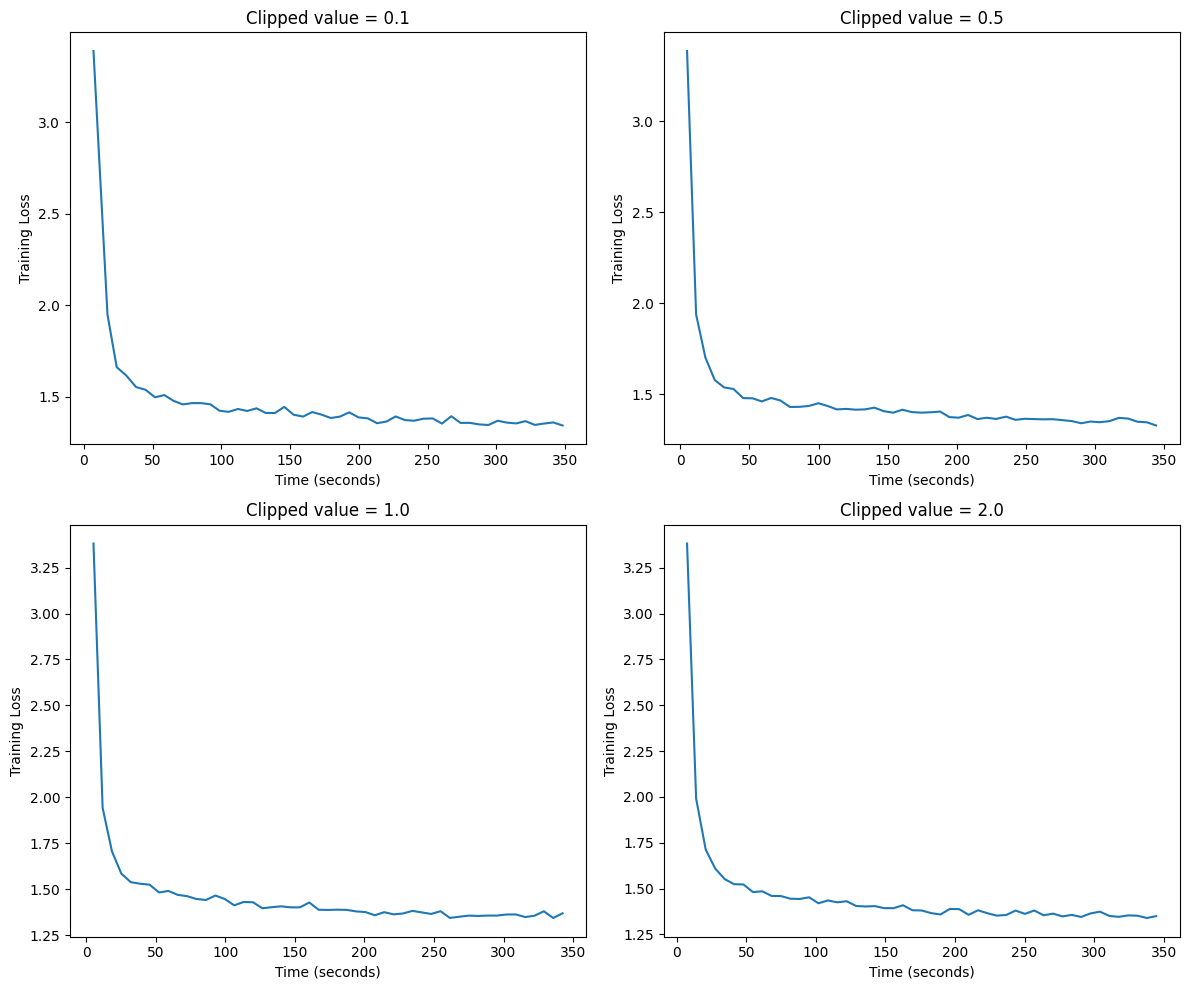

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(len(gradient_clipping)):
    plt.subplot(2, 2, i + 1)
    plt.plot(val_time_all[i], val_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Training Loss")
    plt.title(f"Clipped value = {gradient_clipping[i]}")

plt.tight_layout()
plt.show()

Compare final results and minimum validation loss for general performance metrics

In [ ]:
for i in range(0, len(gradient_clipping)):
    string = f"""
    For a global-norm clipping of {gradient_clipping[i]},
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    For a global-norm clipping of 0.1,
    Final validation loss: 1.3414463996887207
    Total Training Time: 348.2025022506714
    Minimum validation loss: 1.3414463996887207 attained at 348.2025022506714 seconds
    

    For a global-norm clipping of 0.5,
    Final validation loss: 1.327812671661377
    Total Training Time: 344.2875943183899
    Minimum validation loss: 1.327812671661377 attained at 344.2875943183899 seconds
    

    For a global-norm clipping of 1.0,
    Final validation loss: 1.3683942556381226
    Total Training Time: 342.4475202560425
    Minimum validation loss: 1.3428518772125244 attained at 335.70782136917114 seconds
    

    For a global-norm clipping of 2.0,
    Final validation loss: 1.349510908126831
    Total Training Time: 344.6193196773529
    Minimum validation loss: 1.3394156694412231 attained at 337.9002010822296 seconds
    


### **Evaluation**

It appears that a global-norm clipping value of 0.5 gives the best performance metrics, and also has a slightly smoother validation loss curve compared to the other curves. The plot associated with the value 2.0 is a strong contender for smoothest validation loss curve, but performance on the validation set is underwhelming compared to the former.

**Conclusion:** While training loss is very erratic between the four plots, it is normal as the batch size is small. The aim of this experiment is to adopt a gradient clipping threshold for training stability, which will be the clipping value of 0.5. It will be put to the test against an experiment of adaptive gradient clipping, where the clipping value is tuned.



### **Adaptive gradient clipping**

While the previous experiment uses a fixed threshold method to scale down gradients, this method adopts a dynamic adjustment process; using a threshold that changes over time, based on recent gradient norms.

The following parameters are given:
- `clipping`: maximum allowed ratio of update norm to parameter norm
- `eps`: small constant to avoid division by zero. Should not affect experiment.

In [ ]:
lr = cfg['learning_rate']
print(adaptive_gradient)

[0.01, 0.1, 0.5, 1.0]


In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []
training_loss_all = []
training_time_all = []

for g in adaptive_gradient:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    tx = optax.chain(
        optax.adaptive_grad_clip(clipping=g, eps=1e-6),
        optax.lion(learning_rate = lr)
    )
    print(f"Initialized Lion optimizer with adaptive gradient of the clipping value {g}")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_train_history = []
    loss_train_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new
        train_loss = metrics['loss']

        # Keep track of the training loss and time
        loss_train_history.append(train_loss)
        time_train_history.append(time.time() - time_start)

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)
    training_loss_all.append(loss_train_history)
    training_time_all.append(time_train_history)

Initialized Lion optimizer with adaptive gradient of the clipping value 0.01
Initialized Lion optimizer with adaptive gradient of the clipping value 0.1
Initialized Lion optimizer with adaptive gradient of the clipping value 0.5
Initialized Lion optimizer with adaptive gradient of the clipping value 1.0


Similar to the previous experiments with fixed global-norm clipping, the plots below are meant for analysis of training stability.

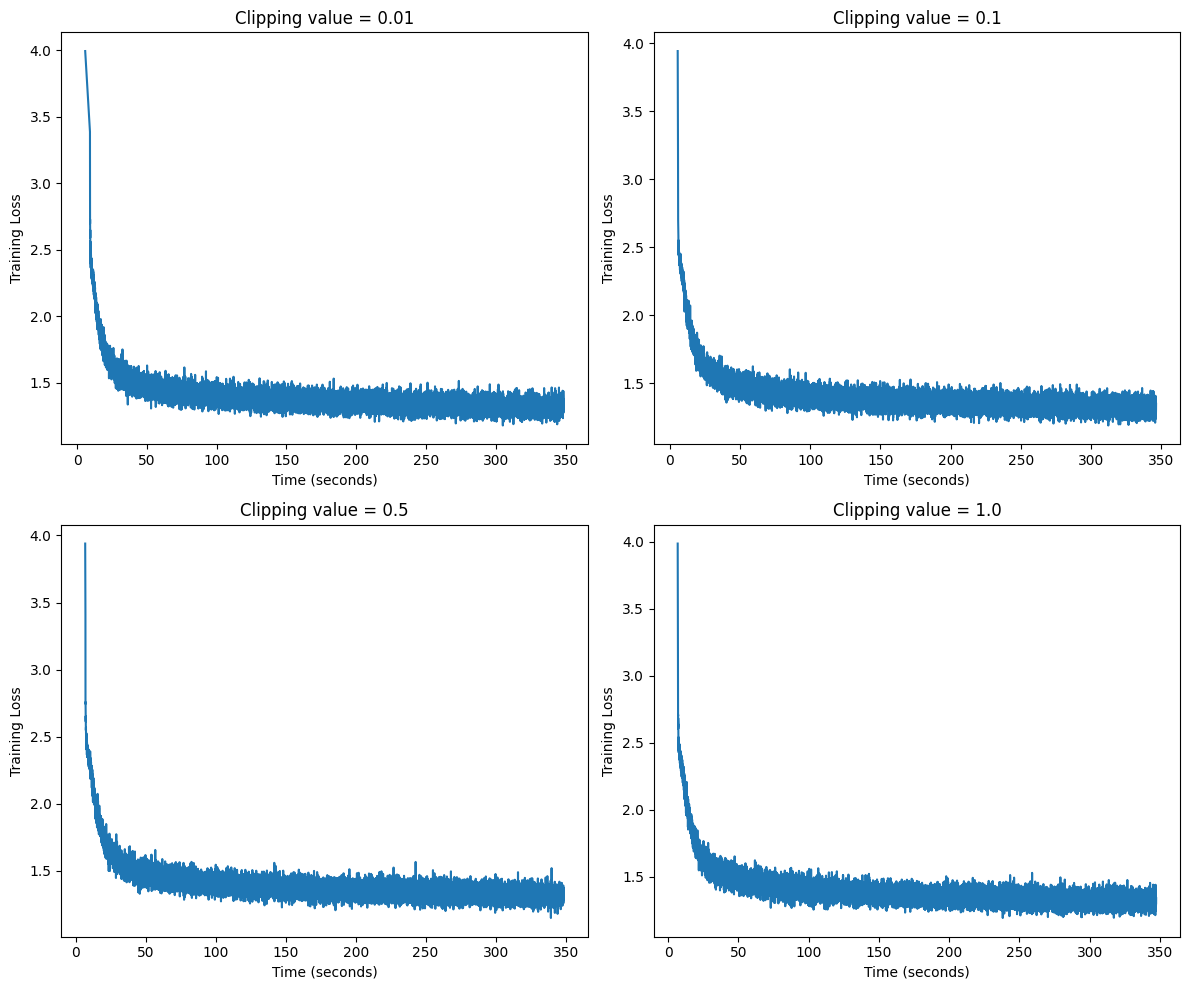

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(len(adaptive_gradient)):
    plt.subplot(2, 2, i + 1)
    plt.plot(training_time_all[i], training_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Training Loss")
    plt.title(f"Clipping value = {adaptive_gradient[i]}")

plt.tight_layout()
plt.show()

Below are plots showing the trend of validation loss over time. It is preferred to have a steady, smooth validation loss curve as this reflects gradient stability.

**Disclaimer**: Ignore the clipped values. The plots should correspond to the values of 0.01, 0.1, 0.5 and 1.0 instead of 0.1, 0.5, 1.0 and 2.0 respectively.

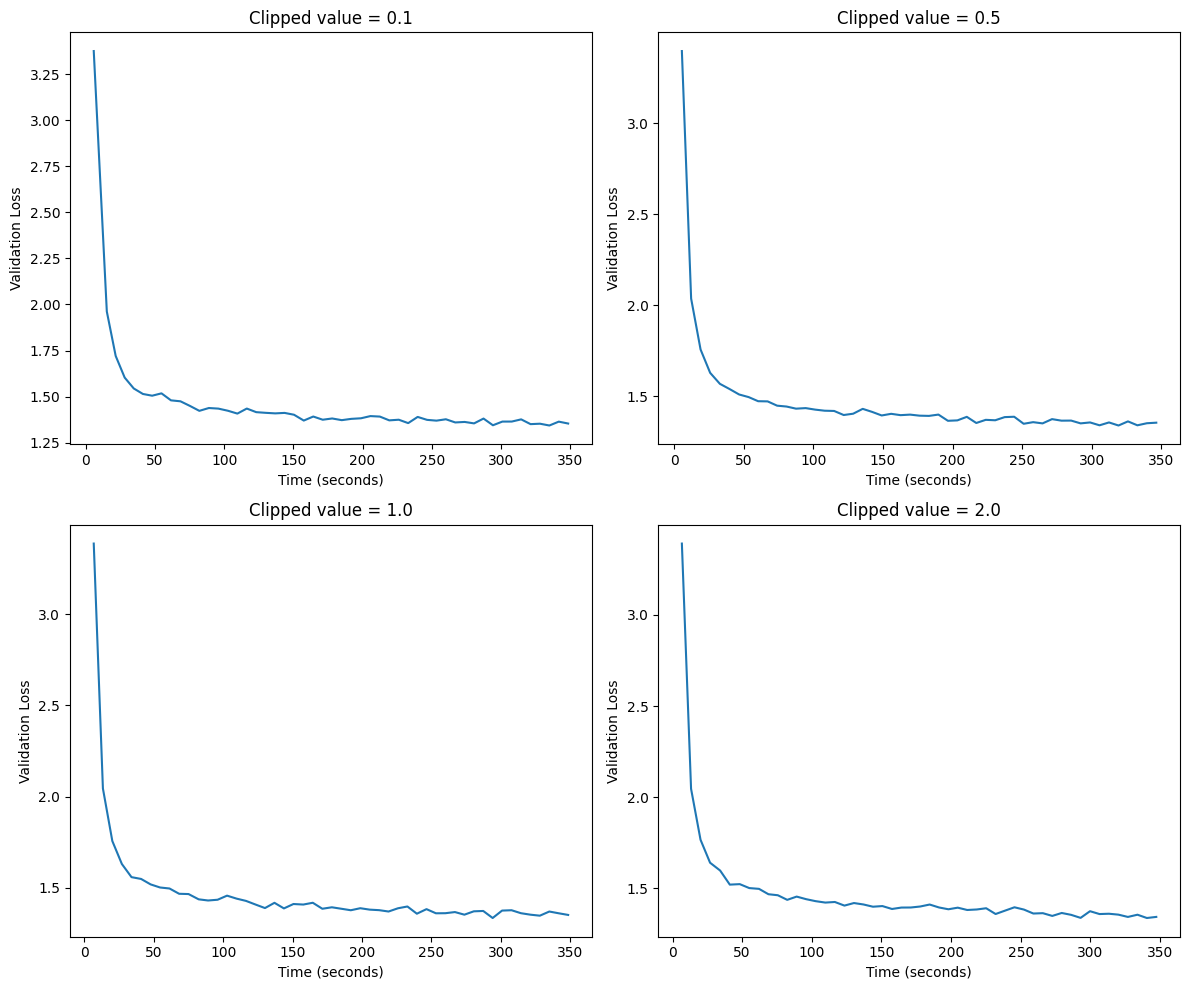

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(len(gradient_clipping)):
    plt.subplot(2, 2, i + 1)
    plt.plot(val_time_all[i], val_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Loss")
    plt.title(f"Clipped value = {gradient_clipping[i]}")

plt.tight_layout()
plt.show()

In [ ]:
for i in range(0, len(adaptive_gradient)):
    string = f"""
    For a global-norm clipping of {adaptive_gradient[i]},
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    For a global-norm clipping of 0.01,
    Final validation loss: 1.3539035320281982
    Total Training Time: 348.52067470550537
    Minimum validation loss: 1.3431941270828247 attained at 334.94518303871155 seconds
    

    For a global-norm clipping of 0.1,
    Final validation loss: 1.355689525604248
    Total Training Time: 346.29948019981384
    Minimum validation loss: 1.340242862701416 attained at 319.16263222694397 seconds
    

    For a global-norm clipping of 0.5,
    Final validation loss: 1.3496053218841553
    Total Training Time: 348.5754671096802
    Minimum validation loss: 1.3327672481536865 attained at 294.18147110939026 seconds
    

    For a global-norm clipping of 1.0,
    Final validation loss: 1.34396493434906
    Total Training Time: 347.3104100227356
    Minimum validation loss: 1.337956428527832 attained at 340.56101417541504 seconds
    


### **Evaluation**

A global-norm clipping of 0.5 appears to have performed the best from the previous two experiments, in terms of model performance, while also boasting a rather smooth validation loss curve, signaling that training is rather stable. This will be adopted moving onto the next experiment.

## **Learning rate scheduling**

After experimenting with weight decay and gradient clipping, continue to customize the optimizer:

This segment will be experimenting with different scheduling strategies, mainly exponential and cosine decay. Warmup is added for each strategy and tuned separately.

Evaluation metrics include minimal validation loss and loss convergence. **Remember** that the sole objective of the project is to optimize performance while adding a few improvements such as regularization and training stability techniques along the way, if they do not suppress performance by much.


### **Cosine decay schedule**

Here, we experiment with cosine learning rate decay schedule (with warmup). There are a few hyperparameters we will tune here, including the warmup duration (`transition_steps`) and number of `decay_steps`.

### **Warmup duration**

Start with a small-scale warmup duration experiment.

In [ ]:
# Initial starting learning rate
print(lr)

# In this section, experiment with different warmup durations
steps = [1_000, 1_500, 2_000, 3_000]

0.0001


In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []

for s in steps:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )
    warmup = optax.linear_schedule(
        init_value = 0.0,
        end_value = lr,
        transition_steps = s
    )

    # cosine decay after warmup with 20_000 steps
    cos_decay = optax.cosine_decay_schedule(
        init_value = lr,
        decay_steps=20_000,
        alpha = 0.0
    )

    schedule = optax.join_schedules(
        schedules=[warmup, cos_decay],
        boundaries=[s]
    )

    tx = optax.chain(
        optax.clip_by_global_norm(0.5),
        optax.lion(learning_rate = schedule)
    )
    print(f"Testing with cosine decay scheduling with {s} warmup transition steps")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_train_history = []
    loss_train_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Testing with cosine decay scheduling with 1000 warmup transition steps
Testing with cosine decay scheduling with 1500 warmup transition steps
Testing with cosine decay scheduling with 2000 warmup transition steps
Testing with cosine decay scheduling with 3000 warmup transition steps


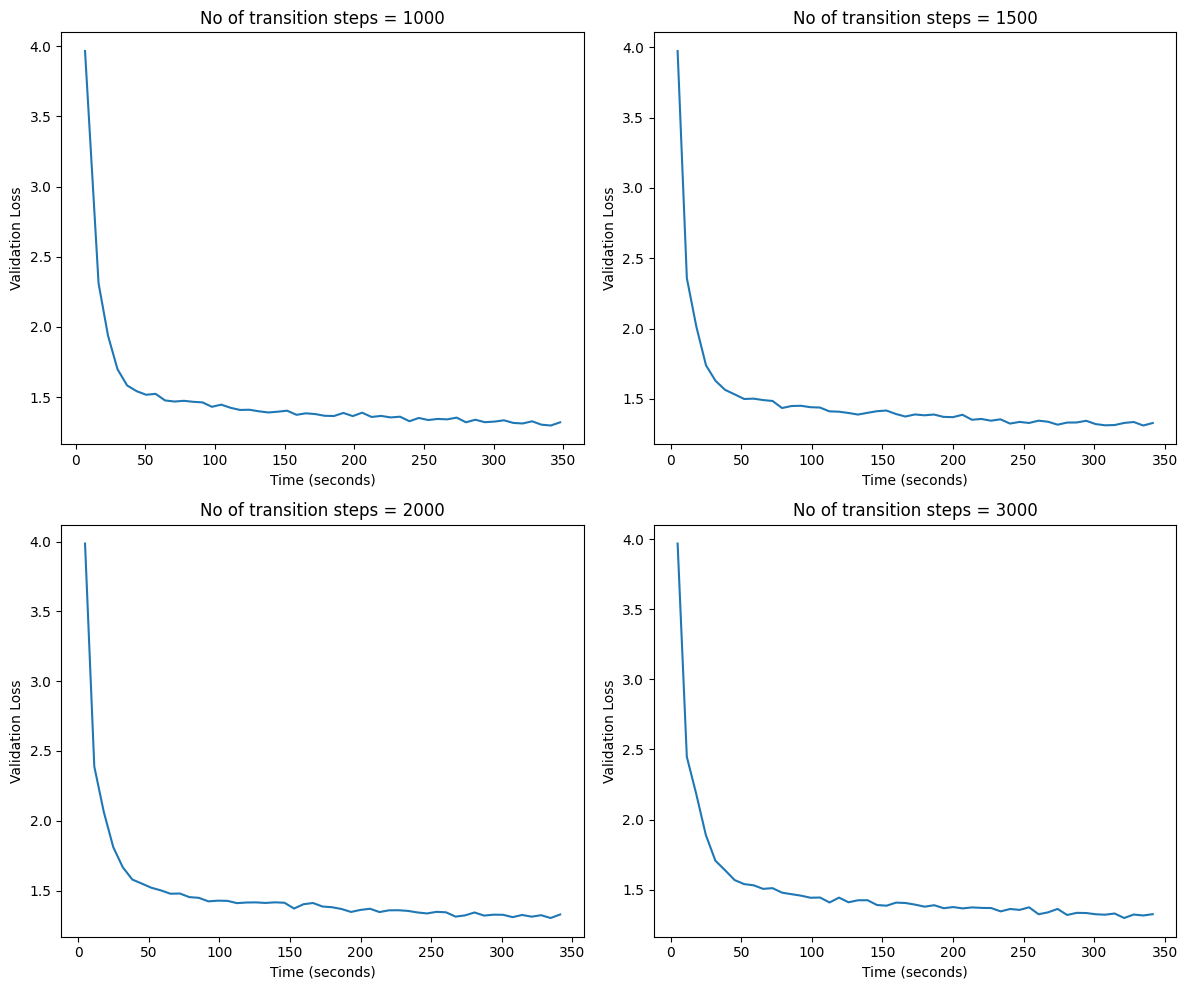

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(len(steps)):
    plt.subplot(2, 2, i + 1)
    plt.plot(val_time_all[i], val_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Loss")
    plt.title(f"No of transition steps = {steps[i]}")

plt.tight_layout()
plt.show()

In [ ]:
# Define function to compare their rates of convergence as analysing the plot is not thorough enough
def hit_150(time, loss):
    idx = 0
    for i in range(0, len(loss)):
        if loss[i]<=1.5:
            idx = i
            break
    return time[idx]


In [ ]:
for i in range(0, len(steps)):
    string = f"""
    For a warmup duration of {steps[i]} transition steps,
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    Minimum Time to hit validation loss of <=1.5: {hit_150(val_time_all[i], val_loss_all[i])} seconds
    """
    print(string)


    For a warmup duration of 1000 transition steps,
    Final validation loss: 1.319920301437378
    Total Training Time: 347.80571722984314
    Minimum validation loss: 1.2972686290740967 attained at 341.1074638366699 seconds
    Minimum Time to hit validation loss of <=1.5: 64.1144859790802 seconds
    

    For a warmup duration of 1500 transition steps,
    Final validation loss: 1.3281519412994385
    Total Training Time: 341.57655787467957
    Minimum validation loss: 1.3104169368743896 attained at 334.86458683013916 seconds
    Minimum Time to hit validation loss of <=1.5: 51.96938705444336 seconds
    

    For a warmup duration of 2000 transition steps,
    Final validation loss: 1.3283195495605469
    Total Training Time: 341.4473841190338
    Minimum validation loss: 1.3031032085418701 attained at 334.72706842422485 seconds
    Minimum Time to hit validation loss of <=1.5: 65.29447221755981 seconds
    

    For a warmup duration of 3000 transition steps,
    Final validati

### **Evaluation**

The best warmup duration is 1000 transition steps. Although it took slightly longer to hit a loss threshold set for analyzing rate of convergence more thoroughly, time difference is not by much, and its performance metrics are slightly better than the other tuned optimizers.

Additionally, the loss curve is smooth. Warmup duration with 1000 steps will be used for future small-scale experiments involving cosine decay schedule.

### **Decay steps**

Another hyperparameter to adjust is the number of `decay_steps` in the cosine decay schedule.

This parameter is the number of steps over which the learning rate will decay with respect to a cosine function.

In [ ]:
# Define a param grid of decay steps
decay = [10_000, 15_000, 20_000, 40_000]

In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []

for d in decay:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    # Warmup
    warmup = optax.linear_schedule(
        init_value = 0.0,
        end_value = lr,
        transition_steps = 1_000
    )

    # cosine decay after warmup
    cos_decay = optax.cosine_decay_schedule(
        init_value = lr,
        decay_steps=d,
        alpha = 0.0
    )

    schedule = optax.join_schedules(
        schedules=[warmup, cos_decay],
        boundaries=[1_000]
    )

    tx = optax.chain(
        optax.clip_by_global_norm(0.5),
        optax.lion(learning_rate = schedule)
    )
    print(f"Testing with cosine decay scheduling with {d} decay steps")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Testing with cosine decay scheduling with 10000 decay steps
Testing with cosine decay scheduling with 15000 decay steps
Testing with cosine decay scheduling with 20000 decay steps
Testing with cosine decay scheduling with 40000 decay steps


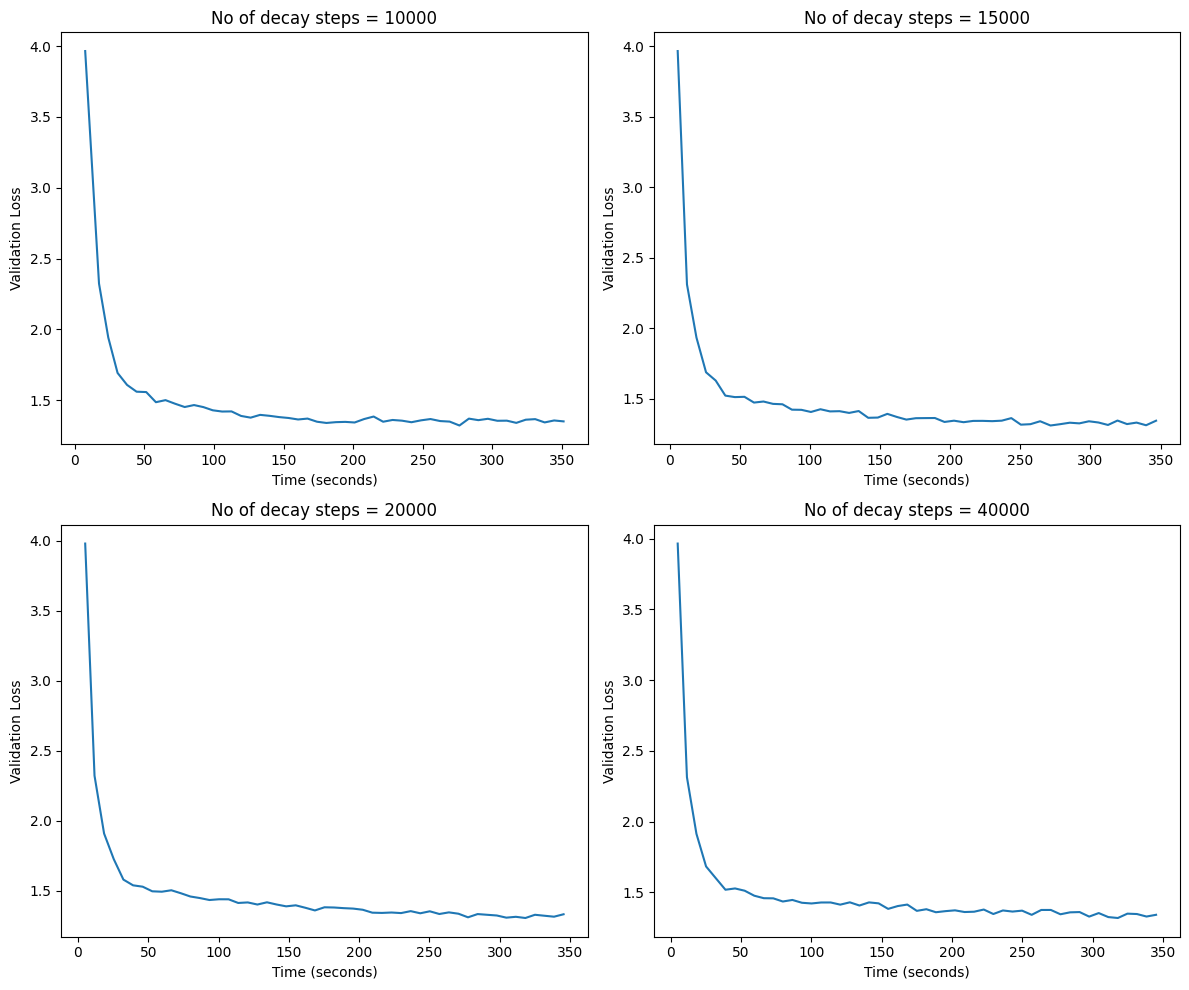

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(len(decay)):
    plt.subplot(2, 2, i + 1)
    plt.plot(val_time_all[i], val_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Loss")
    plt.title(f"No of decay steps = {decay[i]}")

plt.tight_layout()
plt.show()

In [ ]:
for i in range(0, len(decay)):
    string = f"""
    With respect to a cosine function, there are {decay[i]} steps, of which,
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    Minimum Time to hit validation loss of <=1.5: {hit_150(val_time_all[i], val_loss_all[i])} seconds
    """
    print(string)


    With respect to a cosine function, there are 10000 steps, of which,
    Final validation loss: 1.3492391109466553
    Total Training Time: 351.2879376411438
    Minimum validation loss: 1.3201931715011597 attained at 276.43050169944763 seconds
    Minimum Time to hit validation loss of <=1.5: 58.226468086242676 seconds
    

    With respect to a cosine function, there are 15000 steps, of which,
    Final validation loss: 1.3439017534255981
    Total Training Time: 346.7902765274048
    Minimum validation loss: 1.3098368644714355 attained at 271.546279668808 seconds
    Minimum Time to hit validation loss of <=1.5: 60.20579695701599 seconds
    

    With respect to a cosine function, there are 20000 steps, of which,
    Final validation loss: 1.3329174518585205
    Total Training Time: 345.4295995235443
    Minimum validation loss: 1.30625581741333 attained at 318.2815113067627 seconds
    Minimum Time to hit validation loss of <=1.5: 52.853816509246826 seconds
    

    With res

### **Evaluation**

The "20_000 decay steps" model performed the best of the four, although it took a longer time to reach the minimum loss, its minimum loss is the smallest. It also has the fastest rate of convergence to hit a threshold of 1.5 loss.

**Decision**: The best `decay_steps` value is 20_000, with a warmup duration of 1_000 warmup steps.


## **Exponential decay schedule**

The idea of this scheduling strategy is to multiply the learning rate by a decay factor every iteration.

Just like above, there will be two parts to this section:
- Experimenting with different warmup durations with a default `decay_rate` value.
- With the best warmup duration, experiment with different `decay_rate` values to find the best warmup + decay rate combination.

This tuning method is not as vigorous a tuning as a grid search. However, sequential tuning is preferred as training dynamics are better analyzed and hyperparameters often have hierarchical dependencies, compared to grid search, which is one black box of throwing all parameters in and searching for the best outcome.

In [ ]:
# the warmup steps that will be tested
print(lr)
steps = [500, 1_000, 2_000, 3_000]

0.0001


In [ ]:
val_loss_all = []
val_time_all = []

for s in steps:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    schedule = optax.warmup_exponential_decay_schedule(
        init_value = 0.0,
        peak_value = lr,
        # No of steps over which to linearly increase lr
        warmup_steps = s,
        # No of steps after warmup over which exponential decay is applied
        transition_steps = 20_000 - s,
        # Use a default decay rate of 0.99 (will tweak this in later experiment)
        decay_rate = 0.99,
        staircase = False
    )


    tx = optax.chain(
        optax.clip_by_global_norm(0.5),
        optax.lion(learning_rate = schedule)
    )
    print(f"Testing with exponential decay scheduling with {s} warmup transition steps")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_train_history = []
    loss_train_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Testing with exponential decay scheduling with 500 warmup transition steps
Testing with exponential decay scheduling with 1000 warmup transition steps
Testing with exponential decay scheduling with 2000 warmup transition steps
Testing with exponential decay scheduling with 3000 warmup transition steps


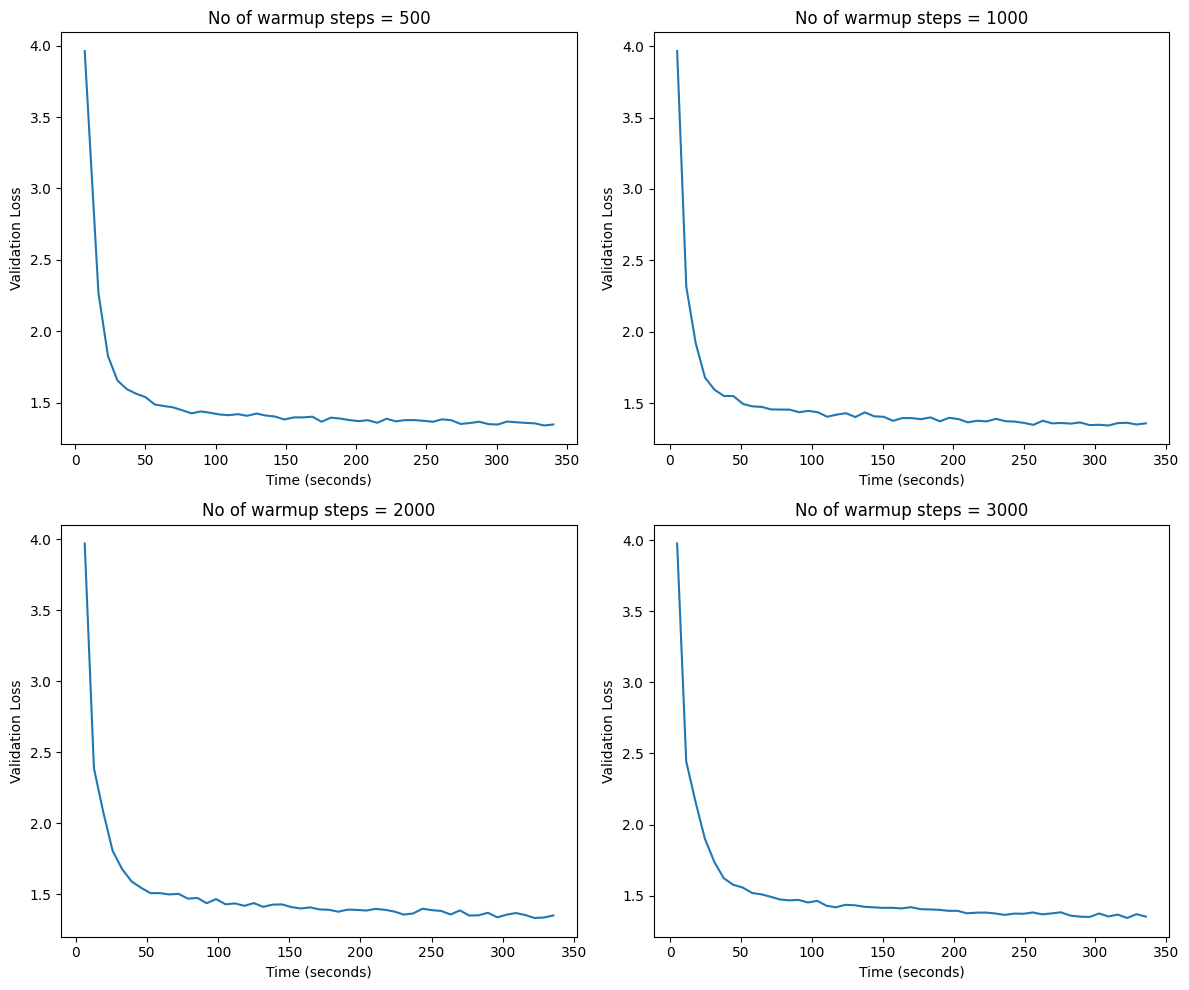

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(len(steps)):
    plt.subplot(2, 2, i + 1)
    plt.plot(val_time_all[i], val_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Loss")
    plt.title(f"No of warmup steps = {steps[i]}")

plt.tight_layout()
plt.show()

In [ ]:
for i in range(0, len(steps)):
    string = f"""
    For a warmup duration of {steps[i]} warmup steps,
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    Minimum Time to hit validation loss of <=1.5: {hit_150(val_time_all[i], val_loss_all[i])} seconds
    """
    print(string)


    For a warmup duration of 500 warmup steps,
    Final validation loss: 1.3476872444152832
    Total Training Time: 340.3473265171051
    Minimum validation loss: 1.3406541347503662 attained at 333.7621953487396 seconds
    Minimum Time to hit validation loss of <=1.5: 56.53222107887268 seconds
    

    For a warmup duration of 1000 warmup steps,
    Final validation loss: 1.3595387935638428
    Total Training Time: 335.5464129447937
    Minimum validation loss: 1.3443763256072998 attained at 309.247918844223 seconds
    Minimum Time to hit validation loss of <=1.5: 51.710615158081055 seconds
    

    For a warmup duration of 2000 warmup steps,
    Final validation loss: 1.3488776683807373
    Total Training Time: 335.68410897254944
    Minimum validation loss: 1.3308589458465576 attained at 322.5127532482147 seconds
    Minimum Time to hit validation loss of <=1.5: 65.578848361969 seconds
    

    For a warmup duration of 3000 warmup steps,
    Final validation loss: 1.352857828

### **Evaluation**

The "2000" warmup steps performed the best, as it has the lowest minimum validation loss. While its rate of convergence might not be the best, as mentioned in my report, performance > convergence rate in priority. If the other "models" have matching performances and faster convergence rates, they could have been used instead.

### **Exponential decay rate**

`decay_rate` is tuned here.

In [ ]:
warmup = 2_000

# Different exponential decay rates
decay_rates = [0.9, 0.99, 0.999]

In [ ]:
val_loss_all = []
val_time_all = []

for d in decay_rates:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    schedule = optax.warmup_exponential_decay_schedule(
        init_value = 0.0,
        peak_value = lr,
        # No of steps over which to linearly increase lr
        warmup_steps = warmup,
        # No of steps after warmup over which exponential decay is applied
        transition_steps = 20_000 - warmup,
        # Tuned decay rates
        decay_rate = d,
        staircase = False
    )


    tx = optax.chain(
        optax.clip_by_global_norm(0.5),
        optax.lion(learning_rate = schedule)
    )
    print(f"Testing with exponential decay scheduling with decay rate of {d}")
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_train_history = []
    loss_train_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Testing with exponential decay scheduling with decay rate of 0.9
Testing with exponential decay scheduling with decay rate of 0.99
Testing with exponential decay scheduling with decay rate of 0.999


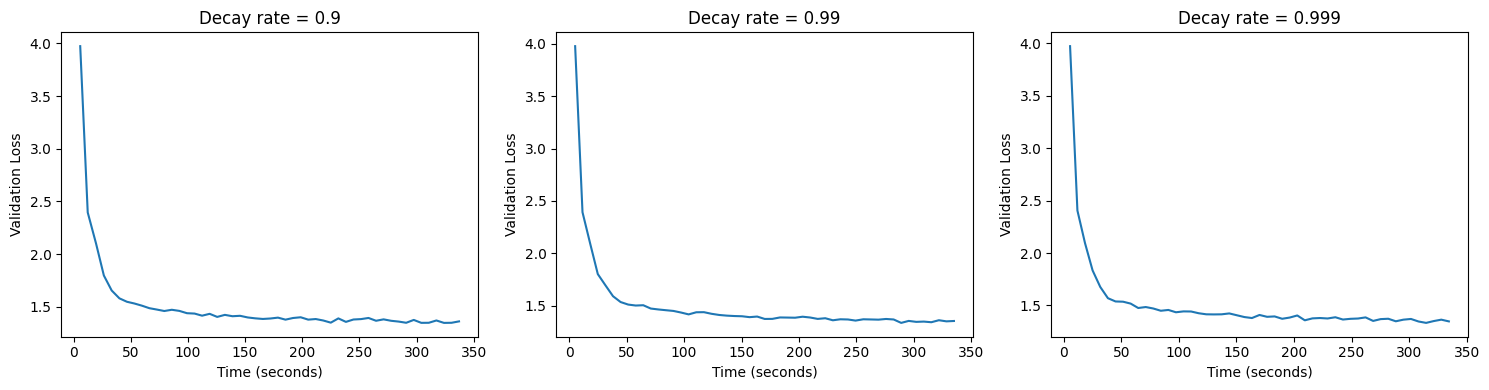

In [ ]:
plt.figure(figsize=(15, 4))

for i in range(len(decay_rates)):
    plt.subplot(1, 3, i + 1)
    plt.plot(val_time_all[i], val_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Loss")
    plt.title(f"Decay rate = {decay_rates[i]}")

plt.tight_layout()
plt.show()

In [ ]:
for i in range(0, len(decay_rates)):
    string = f"""
    For a decay rate of {decay_rates[i]},
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    Minimum Time to hit validation loss of <=1.5: {hit_150(val_time_all[i], val_loss_all[i])} seconds
    """
    print(string)


    For a decay rate of 0.9,
    Final validation loss: 1.3614397048950195
    Total Training Time: 337.08231711387634
    Minimum validation loss: 1.3472106456756592 attained at 323.921639919281 seconds
    Minimum Time to hit validation loss of <=1.5: 66.3120846748352 seconds
    

    For a decay rate of 0.99,
    Final validation loss: 1.3547852039337158
    Total Training Time: 334.75109910964966
    Minimum validation loss: 1.3366522789001465 attained at 288.8720781803131 seconds
    Minimum Time to hit validation loss of <=1.5: 71.08151149749756 seconds
    

    For a decay rate of 0.999,
    Final validation loss: 1.3485369682312012
    Total Training Time: 334.53710436820984
    Minimum validation loss: 1.3342945575714111 attained at 314.7961473464966 seconds
    Minimum Time to hit validation loss of <=1.5: 64.77230072021484 seconds
    


### **Evaluation**

For reference, the best performing cosine decay schedule with a warmup of 1_000 steps has a minimum validation loss of 1.306 attained at 318.28 seconds. It hit the threshold 1.5 at 52.85 seconds.

None of the exponential decay experiments outperform the setup above, in terms of minimum validation loss. They also have slower rates of convergence; taking longer times to hit the threshold.

**Decision**: Moving forward, the best learning rate scheduler is cosine decay schedule (with 20_000 decay steps) and a warmup (of 1_000 warmup steps).